## CPOL Hydrometeor classification

In [26]:
import pyart
import numpy as np
from scipy import ndimage, interpolate
from matplotlib import pyplot as plt
%matplotlib inline
from netCDF4 import Dataset

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:15:56.840798. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [27]:
input_file = '/home/rjackson/data/radar/cfrad.20110202_071003.000_to_20110202_071849.000_CPOL_PPI_level1b.nc'

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:15:57.639429. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [28]:
radar = pyart.io.read(input_file)
radar.info()

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:15:58.083565. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: RuntimeWarning: invalid value encountered in less
  data = self.ncvar[:]
/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: RuntimeWarning: invalid value encountered in greater
  data = self.ncvar[:]
/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/home/rjackson/.local/lib/python3.6/site-packages/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	units: meters
	_FillValue: -9999.0
	positive: up
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	units: meters
	_FillValue: -9999.0
	positive: up
antenna_transition:
	data: <ndarray of type: int8 and shape: (5400,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (5400,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (5400,)>
	long_name: ray_elevation_angle
	units: degrees
	_FillValue: -9999.0
	positive: up
fields:
	temperature:
		data: <ndarray of type: float64 and shape: (5400, 597)>
		long_name: Sounding temperature at gate
		units: degrees Celsius
		standard_name: temperature
		valid_min: -100
		valid_max: 100
		comment: Radiosounding d

## Derive pseudo-NCP

In [29]:
print('Calculating texture....')
nyq_Gunn = radar.instrument_parameters['nyquist_velocity']['data'][0]
data = ndimage.filters.generic_filter(radar.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (3,3),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (3,3))
texture_field = pyart.config.get_metadata('corrected_velocity')
texture_field['data'] = filtered_data
texture_field['data'] = filtered_data
radar.add_field('velocity_texture', texture_field, replace_existing = True)

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:16:29.082297. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Calculating texture....


/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:18:52.301111. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Text(0,0.5,'p.d.f')

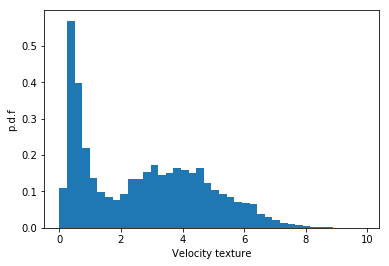

In [30]:
texture = radar.fields['velocity_texture']['data']
plt.hist(texture[texture > 0], normed=1, bins=40)
plt.xlabel('Velocity texture')
plt.ylabel('p.d.f')

In [6]:
## For testing, assume zero psi_dp field
psidp = np.zeros(texture.shape)
radar.add_field_like('PHIDP', 'PSIDP', NCP, replace_existing = True)

NameError: name 'NCP' is not defined

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:20:14.471507. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(-50, 50)

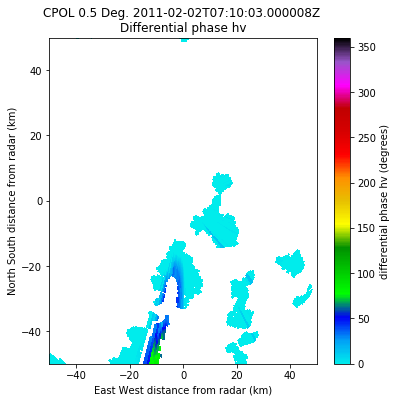

In [35]:
NCP = np.zeros(texture.shape)
NCP[texture < 2] = 1
radar.add_field_like('velocity_texture', 'normalized_coherent_power', NCP, replace_existing = True)
display = pyart.graph.RadarDisplay(radar)
plt.figure(figsize=(6,6))
display.plot_ppi('bringi_differential_phase', vmin=0, vmax=360, cmap=pyart.graph.cm.NWSRef, gatefilter=gatefilter)
plt.xlim([-50,50])
plt.ylim([-50,50])

## Derive KDP

In [36]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('velocity_texture', 2)
gatefilter.exclude_below('cross_correlation_ratio', 0.9)
gatefilter.exclude_masked('corrected_reflectivity')
gatefilter = pyart.correct.despeckle_field(radar, 'corrected_reflectivity', gatefilter=gatefilter, size=30)
#filter_dict = {}
#filter_dict['rhohv_field'] = 'RHOHV'
kdp_dict = pyart.retrieve.kdp_vulpiani(radar,
                                                     gatefilter=gatefilter,
                                                     band='C',
                                                     phidp_field='bringi_differential_phase',
                                                     psidp_field='bringi_differential_phase',
                                                     windsize=4,
                                                     prefilter_psidp=True,
                                                     
                                                     )
print(kdp_dict)

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:20:39.642736. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/rjackson/.local/lib/python3.6/site-packages/pyart/correct/despeckle.py:415: RuntimeWarning: invalid value encountered in less
  cond = np.logical_or(data < tlo, data == BAD)
/home/rjackson/.local/lib/python3.6/site-packages/pyart/retrieve/kdp_proc.py:983: RuntimeWarning: invalid value encountered in less_equal
  kdp_calc[kdp_calc <= th1] = th1
/home/rjackson/.local/lib/python3.6/site-packages/pyart/retrieve/kdp_proc.py:984: RuntimeWarning: invalid value encountered in greater_equal
  kdp_calc[kdp_calc >= th2] = th2


({'units': 'degrees/km', 'standard_name': 'specific_differential_phase_hv', 'long_name': 'Specific differential phase (KDP)', 'coordinates': 'elevation azimuth range', 'data': masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0), 'valid_min': 0.0}, {'data': masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--

In [37]:
#radar.add_field('specific_differential_phase', reproc_phase, replace_existing = True)
radar.add_field('corrected_differential_phase', kdp_dict[0], replace_existing = True)

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-06 10:20:49.796942. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-07 11:32:51.845602. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(-50, 50)

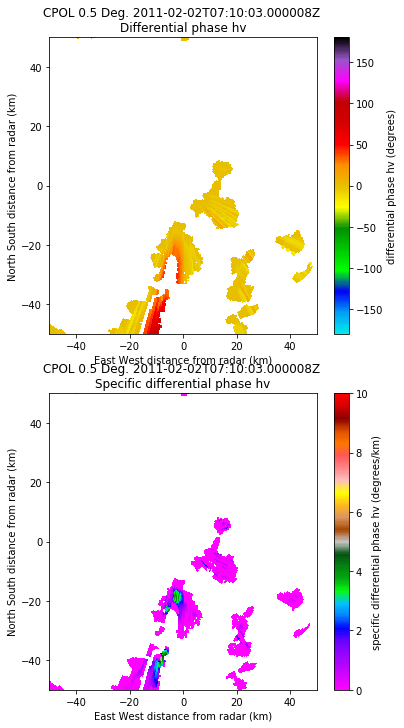

In [39]:
plt.figure(figsize=(6,12))
plt.subplot(212)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_differential_phase', vmin=0, vmax=10, gatefilter=gatefilter,)
plt.xlim([-50,50])
plt.ylim([-50,50])

plt.subplot(211)
display.plot_ppi('bringi_differential_phase', vmin=-180, vmax=180, gatefilter=gatefilter,
                 cmap=pyart.graph.cm.NWSRef)
plt.xlim([-50,50])
plt.ylim([-50,50])

In [67]:
altitudes = radar.gate_altitude['data']

sounding_input_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20111202.111900.custom.cdf'
Sounding_netcdf = Dataset(sounding_input_file, mode='r')

# Convert timestamps to datetime format
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
u = Sounding_netcdf.variables['u_wind'][:]
v = Sounding_netcdf.variables['v_wind'][:]
t = Sounding_netcdf.variables['tdry'][:]

function = interpolate.interp1d(alt,t,bounds_error=False)
temp = np.zeros(altitudes.shape)

for j in range(0,592):
    temp[:,j] = function(altitudes[:,j])

radar.add_field_like('specific_differential_phase', 
                     'temperature', temp, replace_existing = True)
display.plot_ppi('temperature', vmin=-20, vmax=30, sweep=2,
                 cmap=pyart.graph.cm.NWSRef)
#plt.plot(alt,t)

/home/rjackson/anaconda3/envs/jordi_pyart/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-02-05 11:18:12.102396. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


ValueError: field specific_differential_phase does not exist in object

In [12]:
hydrometeor_class = pyart.retrieve.hydroclass_semisupervised(radar, 
                                                             refl_field='Refl',
                                                             rhv_field='RHOHV',
                                                             temp_field='temperature',
                                                             zdr_field='ZDR',
                                                             kdp_field='corrected_differential_phase',
                                                             weights=np.array([1.0, 
                                                                               0.75,
                                                                               1.,
                                                                               0.75,
                                                                               0.5]))
radar.add_field('hydrometeor_class', hydrometeor_class, replace_existing=True)

/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/numpy/ma/core.py:812: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


{'units': 'legend', 'long_name': 'Radar Echo classification', 'standard_name': 'radar_echo_classification', 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0]]), 'coordinates': 'elevation azimuth range'}
{'units': 'legend', 'long_name': 'Radar Echo classification', 'standard_name': 'radar_echo_classification', 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0]]), 'coordinates': 'elevation azimuth range'}


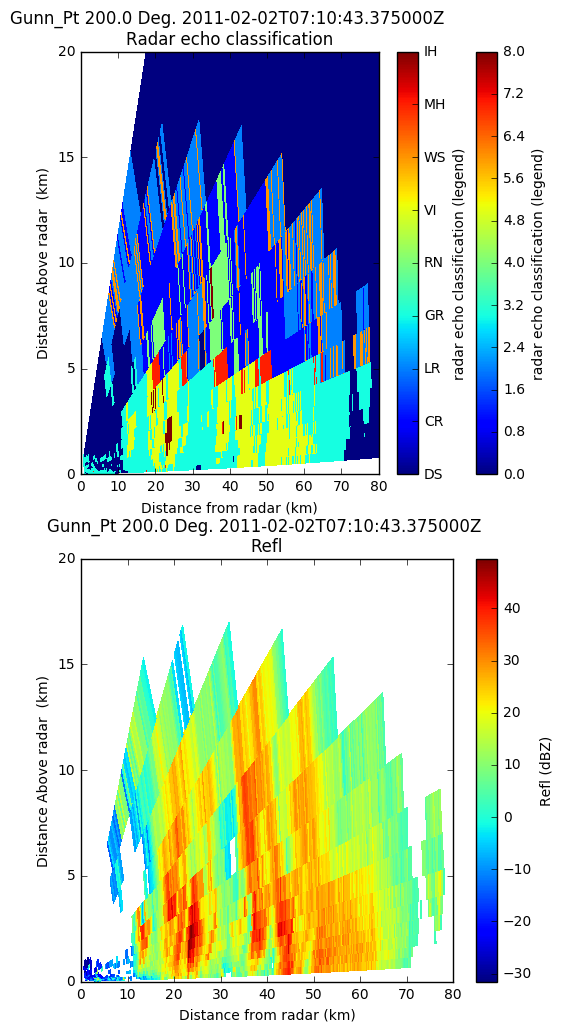

In [13]:
radar_xsection = pyart.util.cross_section_ppi(radar, [200])

display_xsection = pyart.graph.RadarMapDisplay(radar_xsection)
plt.figure(figsize=(6,12))
plt.subplot(211)
display_xsection.plot_rhi('hydrometeor_class',
                          vmin=0,
                          vmax=8)
plt.ylim([0,20])
plt.xlim([0,80])
print(np.max(hydrometeor_class))
display_xsection.plot_colorbar(ticks=[0,1,2,3,4,5,6,7,8],
                               ticklabs=['DS','CR', 
                                         'LR','GR',
                                         'RN','VI',
                                         'WS','MH',
                                         'IH'])

plt.subplot(212)
display_xsection.plot_rhi('Refl')
plt.ylim([0,20])
plt.xlim([0,80])
print(hydrometeor_class)
